## Environment setup

In [ ]:
import vitaldb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer



## API data load and save on disk

Load and save the data

### Read healthy patients data

In [ ]:
caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
# Load dataset
df = pd.read_csv('https://api.vitaldb.net/cases')
df = df[df['asa'] < 3] # Extract ids of patients with asa < 3 and not dead in hospital
df = df[df['death_inhosp'] == False]

caseids_healthy = df['caseid'].to_numpy() # extract the case ids of patience with good health
caseids = [el for el in caseids_all if el in caseids_healthy]
print(len(caseids))


In [ ]:
ecg = []
dbp = []
sbp = []
bt  = []
hr  = []
rr  = []
# load all the patients data 
for i in range(0,len(caseids)): # Select only five patient for testing purpose; then len(caseids)
    try:
        vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
        dbp.append(vals[:,0])
        sbp.append(vals[:,1])
        bt.append(vals[:,2])
        hr.append(vals[:,3])
        rr.append(vals[:,4])

        # extract non-null values
        dbp[i] = dbp[i][~np.isnan(dbp[i])]  
        sbp[i] = sbp[i][~np.isnan(sbp[i])] 
        bt[i] = bt[i][~np.isnan(bt[i])]
        hr[i] = hr[i][~np.isnan(hr[i])] 
        rr[i] = rr[i][~np.isnan(rr[i])]
    
    except Exception as e: 
        print('\n=================\n')
        print('INDEX: '+str(i))
        print('ERROR: '+str(type(e)))
        print('\n=================\n')
        pass


for i in range(0,len(caseids)):
    #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
    vals = vitaldb.load_case(caseids[i], ['ECG_II'])
    ecg.append(vals[:,0])


In [ ]:
# save the data into a file since loading all the 2k caseids requires at least 1h
filepath = '/Users/Roberto/projects/siiaproject-vitanomaly/data.vitaldb'
ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'
ecgpath = '/Users/Roberto/projects/siiaproject-vitanomaly/ecg_data.vitaldb'


In [ ]:
# save the data into a file since loading all the 2k caseids requires at least 1h

with open(filepath, 'wb') as f:
    pickle.dump((dbp,sbp,bt,hr,rr), f)

with open(ecgpath, 'wb') as f:
    pickle.dump(ecg, f)



## Preprocessing

In [ ]:
ecg = []
dbp = []
sbp = []
bt  = []
hr  = []
rr  = []

# save the data into a file since loading all the 2k caseids requires at least 1h
filepath = '/Users/Roberto/projects/siiaproject-vitanomaly/numeric_data.vitaldb'
ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'
ecgpath = '/Users/Roberto/projects/siiaproject-vitanomaly/ecg_data.vitaldb'

with open(ecgpath, 'rb') as f:
    (ecg) = pickle.load(f)
with open(filepath, 'rb') as f:
    (dbp,sbp,bt,hr,rr) = pickle.load(f)

In [ ]:
# remove empty elements

for i in range(0,len(dbp) - len([el for el in dbp if len(el) == 0])):
    if(len(dbp[i])==0):
        dbp.pop(i)

for i in range(0,len(sbp) - len([el for el in sbp if len(el) == 0])):
    if(len(sbp[i])==0):
        sbp.pop(i)

for i in range(0,len(bt) - len([el for el in bt if len(el) == 0])):
    if(len(bt[i])==0):
        bt.pop(i)

for i in range(0,len(hr) - len([el for el in hr if len(el) == 0])):
    if(len(hr[i])==0):
        hr.pop(i)

for i in range(0,len(rr) - len([el for el in rr if len(el) == 0])):
    if(len(rr[i])==0):
        rr.pop(i)

for i in range(0,len(ecg) - len([el for el in ecg if len(el) == 0])):
    if(len(ecg[i])==0):
        ecg.pop(i)

In [ ]:
# Lists should have the same length i.e. len(caseids)
# Normalization can be done with a keras layer from preprocessing library
np.seterr(all='raise')
idx_remove = []
for i in range(0,len(ecg)): 
    try:
        #Remove negative values
        ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i]) 
        # MinMax normalization
        ecg[i] = (ecg[i] - np.min(ecg[i]))/(np.max(ecg[i])-np.min(ecg[i])) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)

for idx in idx_remove: 
    ecg.pop(idx)

idx_remove = []
for i in range(0,len(dbp)): 
    try:
        #Remove negative values
        dbp[i][np.argwhere(dbp[i]<0)] = np.mean(dbp[i]) 
        # MinMax normalization
        dbp[i] = (dbp[i] - np.min(dbp[i]))/(np.max(dbp[i])-np.min(dbp[i])) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)

for idx in idx_remove: 
    dbp.pop(idx)

idx_remove = []  
for i in range(0,len(sbp)): 
    try:
        #Remove negative values
        sbp[i][np.argwhere(sbp[i]<0)] = np.mean(sbp[i]) 
        # MinMax normalization
        sbp[i] = (sbp[i] - np.min(sbp[i]))/(np.max(sbp[i])-np.min(sbp[i])) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)

for idx in idx_remove: 
    sbp.pop(idx)



idx_remove = []
for i in range(0,len(bt)): 
    try:
        #Remove negative values
        bt[i][np.argwhere(bt[i]<0)] = np.mean(bt[i]) 
        # MinMax normalization
        bt[i] = (bt[i] - np.min(bt[i]))/(np.max(bt[i])-np.min(bt[i])) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)

for idx in idx_remove: 
    bt.pop(idx)



idx_remove = []
for i in range(0,len(hr)): 
    try:
        #Remove negative values
        hr[i][np.argwhere(hr[i]<0)] = np.mean(hr[i]) 
        # MinMax normalization
        hr[i] = (hr[i] - np.min(hr[i]))/(np.max(hr[i])-np.min(hr[i])) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)

for idx in idx_remove: 
    hr.pop(idx)


idx_remove = []
for i in range(0,len(rr)): 
    try:
        #Remove negative values
        rr[i][np.argwhere(rr[i]<0)] = np.mean(rr[i]) 
        # MinMax normalization
        rr[i] = (rr[i] - np.min(rr[i]))/(np.max(rr[i])-np.min(rr[i])) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)

for idx in idx_remove: 
    rr.pop(idx)



In [ ]:
p = np.argmax([len(el) for el in sbp])
plt.figure(figsize=(20,10))
plt.subplot(511)
plt.title("DBP")
plt.plot(dbp[p], color='b')
plt.subplots_adjust(hspace=1.)
plt.subplot(512)
plt.title("SBP")
plt.plot(sbp[p][:], color='r')

plt.subplot(513)
plt.title("Body temperature")
plt.plot(bt[p][:], color='orange')

plt.subplot(514)
plt.title("Heart rate")
plt.plot(hr[p][:], color='r')

plt.subplot(515)
plt.title("Respiratory rate")
plt.plot(rr[p][:], color='g')
plt.show()

## Train autoencoder

In [ ]:
flat_list = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
chunks = np.array_split(flat_list,2000)

In [ ]:
len(chunks[1])

In [45]:
ntrain = int(len(chunks) * 0.7) # 70% percent of data fro training
max_lenght = max([len(el) for el in chunks])
# Uniform lenghts
X_train = pad_sequences(chunks, max_lenght,padding='post',value=0.5,dtype='float64')
print(np.shape(X_train))

(2000, 8833)


In [82]:
n_dim = X_train.shape[1]
#input Layer
input_layer = tf.keras.layers.Input(shape=(n_dim,))
#Encoder
encoder = tf.keras.layers.Dense(512, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(0.0005))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(256, activation='tanh')(encoder)
encoder = tf.keras.layers.Dense(128, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
# Decoder
decoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(128, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(256, activation='tanh')(decoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(512, activation='tanh')(decoder)
decoder = tf.keras.layers.Dense(n_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8833)]            0         
                                                                 
 dense_27 (Dense)            (None, 512)               4523008   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 64)                4160

In [83]:
autoencoder.fit(X_train,X_train,epochs=15,batch_size=64,validation_split=0.2)

Epoch 1/15
25/25 [==============================] - 5s 113ms/step - loss: 0.2709 - accuracy: 0.0000e+00 - val_loss: 0.2531 - val_accuracy: 0.0175
Epoch 2/15
25/25 [==============================] - 3s 107ms/step - loss: 0.2522 - accuracy: 6.2500e-04 - val_loss: 0.2439 - val_accuracy: 0.0175
Epoch 3/15
25/25 [==============================] - 3s 136ms/step - loss: 0.2452 - accuracy: 0.0012 - val_loss: 0.2414 - val_accuracy: 0.0175
Epoch 4/15
25/25 [==============================] - 3s 122ms/step - loss: 0.2433 - accuracy: 0.0019 - val_loss: 0.2409 - val_accuracy: 0.0000e+00
Epoch 5/15
25/25 [==============================] - 3s 133ms/step - loss: 0.2471 - accuracy: 0.0044 - val_loss: 0.2456 - val_accuracy: 0.0000e+00
Epoch 6/15
25/25 [==============================] - 3s 124ms/step - loss: 0.2437 - accuracy: 0.0019 - val_loss: 0.2393 - val_accuracy: 0.0000e+00
Epoch 7/15
25/25 [==============================] - 3s 111ms/step - loss: 0.2442 - accuracy: 0.0000e+00 - val_loss: 0.2396 - val

(16332,)
1/1 [==============================] - 0s 25ms/step
39.10852891707767
27.075867
12.03266221785892


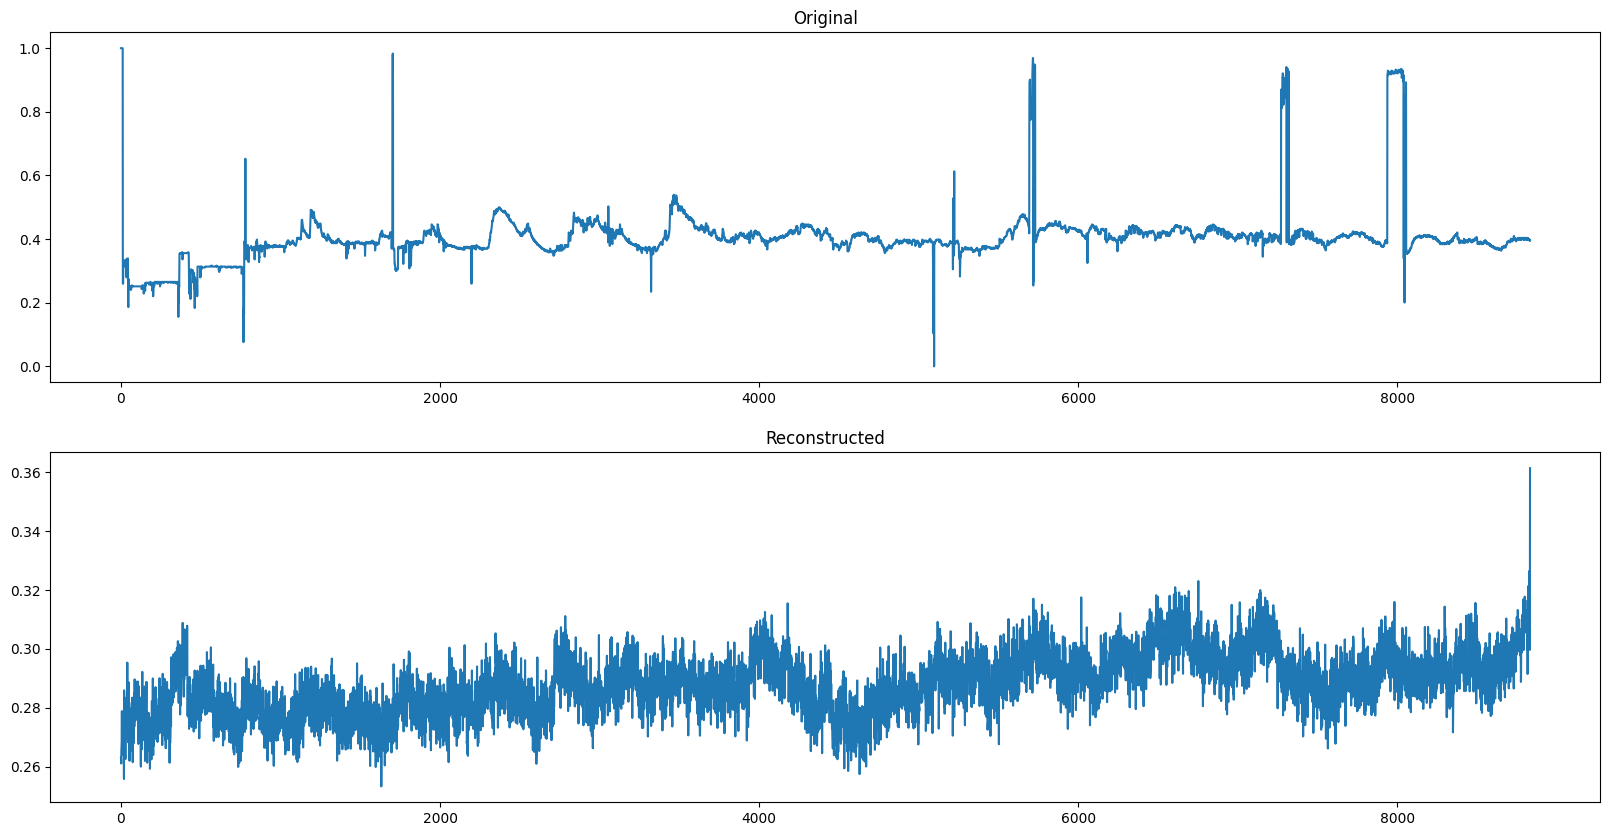

In [79]:
val_p = vitaldb.load_case(264, ['ART_DBP','ART_SBP','BT','HR','RR'])
test = val_p[:,0]

test = test[~np.isnan(test)] 

print(np.shape(test))
test = test[:8833]
test = (test-np.min(test))/(np.max(test)-np.min(test))


res = autoencoder.predict(np.expand_dims(test,axis=0))

print(np.linalg.norm(test,2))
print(np.linalg.norm(res[0],2))
print(abs(np.linalg.norm(test,2)-np.linalg.norm(res[0],2)))

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Original')
plt.plot(test)

plt.subplot(212)
plt.title('Reconstructed')

plt.plot(res[0],scaley=1.)


In [ ]:
# Test on a patient. NB: the data has to be normalized with MinMax approach
#val_p = vitaldb.load_case(17, ['ART_DBP','ART_SBP','BT','HR','RR'])
#
## Pre-processing: remove nan vals, normalize and padding
#val_p = val_p[~np.isnan(val_p)]
#val_p = (val_p-np.min(val_p))/(np.max(val_p)-np.min(val_p))
#test = pad_sequences([val_p],max_lenght,padding='post',value=0.5,dtype='float64')
#
#res = autoencoder.predict(test)
#
## The error for case 464 (ill patient) is much greater than case 17 (healthy patient)
#print(np.linalg.norm(test,2))
#print(np.linalg.norm(res[0],2))
#print(abs(np.linalg.norm(test,2)-np.linalg.norm(res[0],2)))

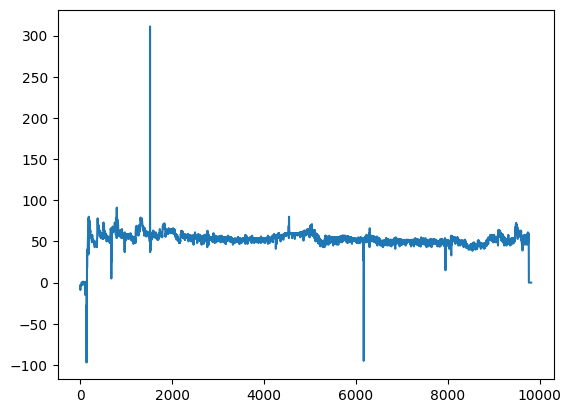

### Read UNHEALTHY patients data

In [62]:

caseids_all = vitaldb.find_cases(['ART_DBP','ART_SBP']) # find ids of patient with this parameters
# Load dataset
df = pd.read_csv('https://api.vitaldb.net/cases')
df = df[df['asa'] > 3]
# df = df[df['death_inhosp'] == False] 

caseids_unhealthy = df['caseid'].to_numpy() #extract the case ids of patience with good health

caseids = [el for el in caseids_all if el in caseids_unhealthy]

dbp = []
sbp = []
# load all the patients data into bp
for i in range(0,5):
    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP'])
    dbp.append(vals[:,0])
    sbp.append(vals[:,1])
    dbp[i] = dbp[i][~np.isnan(dbp[i])] # extract non-null values of dyastolic pressure
    sbp[i] = sbp[i][~np.isnan(sbp[i])] # extract non-null values of systolic pressure
    sbp[i][np.argwhere(sbp[i]<0)] = np.mean(sbp[i]) # Threshold on 50 and then substitute with the mean value of the single patient data
    dbp[i][np.argwhere(dbp[i]<0)] = np.mean(dbp[i]) # Threshold on 50 and then substitute with the mean value of the single patient data

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(dbp[4][:], color='b')
plt.subplot(212)
plt.plot(sbp[4][:], color='r')
plt.show()